In [1]:
import jax
import jax.numpy as jnp

from flax import linen as nn
from flax.training import train_state
from flax.linen.initializers import glorot_normal

import optax
from typing import Callable

import jax.random as random
from jax import grad

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from jax.lax import stop_gradient

In [2]:
import matplotlib.pyplot as plt

def plot_loss_over_time(loss_values):
    """
    Plots the loss over time.

    Parameters:
    loss_values (list of float): List of loss values at each epoch or time step.

    """
    plt.figure(figsize=(10, 5))
    plt.plot(loss_values, color='orange', linestyle='-')
    plt.title("Loss over Time")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

In [3]:
glorot = glorot_normal()
class MLP(nn.Module):
    num_hidden: int
    num_output: int
    kernel_init: Callable = glorot

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.num_hidden, kernel_init=self.kernel_init)(x)
        x = nn.tanh(x)
        x = nn.Dense(self.num_hidden, kernel_init=self.kernel_init)(x)
        x = nn.tanh(x)
        x = nn.Dense(self.num_output, kernel_init=self.kernel_init)(x)
        return x

In [4]:
class Config:
    learning_rate = 1e-3          # Initial learning rate
    decay_steps = 1000            # Decay every 1000 steps
    decay_rate = 0.9              # Multiply LR by 0.9 at each decay step
    staircase = True              # Stepwise decay
    

config = Config()

In [5]:
key = random.PRNGKey(0)
model = MLP(num_hidden=64, num_output=1)
input_shape = (2,)

# Create the exponential decay schedule
lr = optax.exponential_decay(
    init_value=config.learning_rate,
    transition_steps=config.decay_steps,
    decay_rate=config.decay_rate,
    staircase=config.staircase,
)

state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=model.init(key, jnp.ones(input_shape)),
    tx=optax.adam(learning_rate=lr)        
)

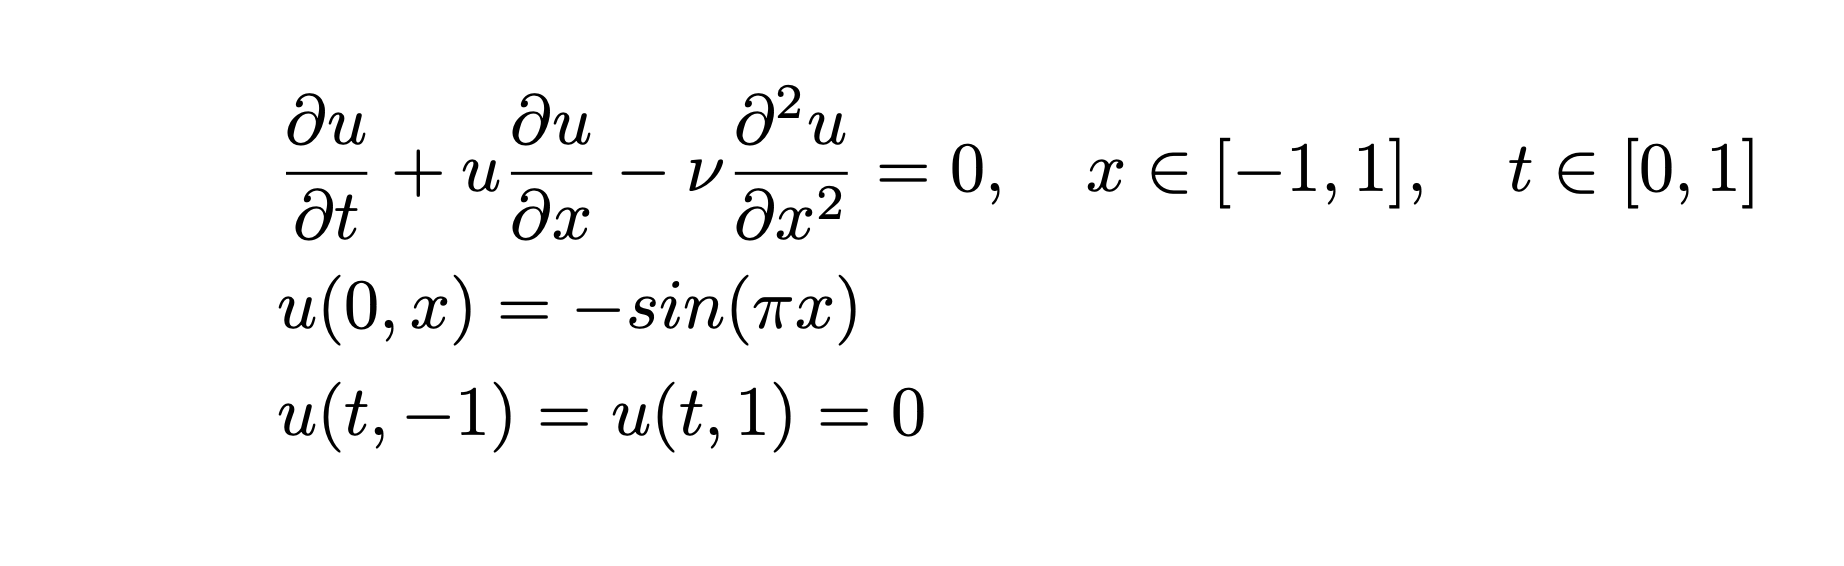

$v = 1/100\pi$

In [6]:
@jax.jit
def fwd(params, state, x, t):
    pred = state.apply_fn(params, jnp.array([x, t]))
    return pred[0]

@jax.jit
def pinn_loss(params, state, x, t):
    u = fwd(params, state, x, t)
    v = (100 * jnp.pi) ** -1
    
    u_x = grad(fwd, argnums=2)(params, state, x, t)
    u_xx = grad(grad(fwd, argnums=2), argnums=2)(params, state, x, t)
 
    u_t = grad(fwd, argnums=3)(params, state, x, t)
    
    return (u_t + u*u_x -v*u_xx) ** 2

@jax.jit
def bc_loss(params, state, x, t, true):
    return (fwd(params, state, x,t) - true) ** 2

x = 0.
t = 1.
pinn_loss(state.params, state, x, t), bc_loss(state.params, state, x, t, 0.)

(Array(0.02188781, dtype=float32), Array(0.01224012, dtype=float32))

In [7]:
@jax.jit
def loss_fn(params, x, t):
    bc_1 = bc_loss(params, state, -1., t, 0.)
    bc_2 = bc_loss(params, state, 1., t, 0.)
    
    ic = bc_loss(params, state, x, 0., -jnp.sin(jnp.pi*x))
    
    res = pinn_loss(params, state, x, t) 

    return res + bc_1 + bc_2 + ic

@jax.jit
def train_step(state, x, t):
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params, x, t)

    state = state.apply_gradients(grads=grads)
    return state, loss


T_MAX = 1
X_MIN = -1
X_MAX = 1

N_EPOCHS = 100 
STEPS = 1000

for epoch in (pbar := tqdm(range(N_EPOCHS))):
    mean_loss = 0
    for i in range(STEPS):
        key, _ = random.split(key)
        x = random.uniform(key, minval=X_MIN, maxval=X_MAX, shape=(1,))[0]
        key, _ = random.split(key)
        t = random.uniform(key, minval=0, maxval=T_MAX, shape=(1,))[0]

        state, loss = train_step(state, x, t)
        mean_loss += loss / STEPS  # Accumulate mean loss over STEPS
        break
    break
    # Update tqdm bar with mean loss
    pbar.set_description(f"Loss {mean_loss: .4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

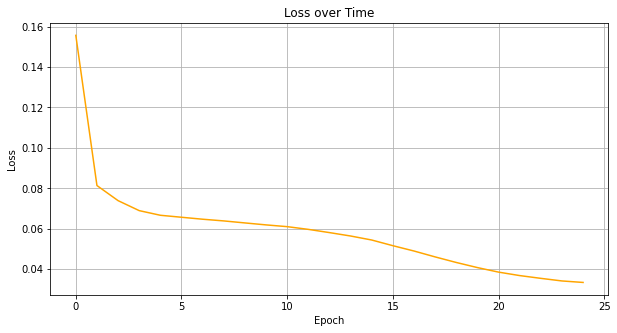

In [8]:
@jax.jit
def batch_train_step(state, x, t):
    def loss_fn(params, x, t):
        bc_1 = bc_loss(params, state, -1., t, 0.)
        bc_2 = bc_loss(params, state, 1., t, 0.)

        ic = bc_loss(params, state, x, 0., -jnp.sin(jnp.pi*x))

        res = pinn_loss(params, state, x, t) 

        return res + bc_1 + bc_2 + ic
    
    def batched_loss(params, x, t):
        losses = jax.vmap(loss_fn, (None, 0, 0))(params, x, t)

        cum_loss = jnp.cumsum(stop_gradient(losses))
        weights = jnp.exp(-cum_loss / jnp.max(cum_loss))
        
        loss = jnp.mean(weights * losses)

        return loss

    grad_fn = jax.value_and_grad(batched_loss)
    loss, grads = grad_fn(state.params, x, t)

    state = state.apply_gradients(grads=grads)

    return state, loss


T_MAX = 1
X_MIN = -1
X_MAX = 1
N_EPOCHS = 25
STEPS = 1000
BS = 128

losses = []
for epoch in (pbar := tqdm(range(N_EPOCHS))):
    mean_loss = 0
    for i in range(STEPS):
        key, _ = random.split(key)
        x = random.uniform(key, minval=X_MIN, maxval=X_MAX, shape=(BS,))
        key, _ = random.split(key)
        t = random.uniform(key, minval=0, maxval=T_MAX, shape=(BS,))
        t = t.sort(axis=-1)
            
        state, loss = batch_train_step(state, x, t)
    
        mean_loss += loss   # Accumulate mean loss over STEPS
    mean_loss = mean_loss / STEPS
    losses.append(mean_loss)
        
    # Update tqdm bar with mean loss
    pbar.set_description(f"Loss {mean_loss: .4f}")
    
plot_loss_over_time(losses)

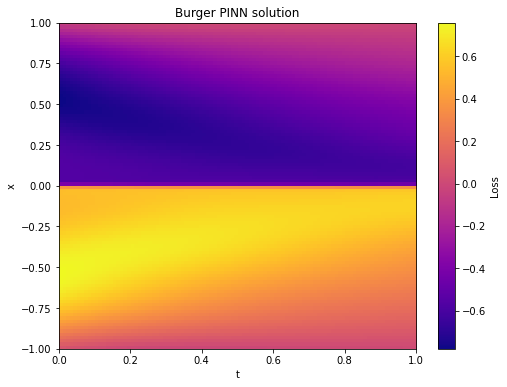

In [9]:
N = 100
x_grid = jnp.linspace(X_MIN, X_MAX, N)
t_grid = jnp.linspace(0, T_MAX, N)

# jax.vmap(fwd, (None, None, 0, 0))(state.params, state, x_grid, t_grid)
# Create a meshgrid of x and t values
x_mesh, t_mesh = jnp.meshgrid(x_grid, t_grid, indexing="ij")
x_flat = x_mesh.flatten()
t_flat = t_mesh.flatten()

# Use vmap over the flattened array
results_flat = jax.vmap(fwd, (None, None, 0, 0))(state.params, state, x_flat, t_flat)

# Reshape the result back into a (50, 50, ...) grid
results = results_flat.reshape((N, N, -1))  # Adjust shape based on fwd's output
results.shape

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(results, extent=(0, T_MAX, X_MIN, X_MAX), origin="lower", aspect="auto", cmap="plasma")
plt.colorbar(label="Loss")
plt.xlabel("t")
plt.ylabel("x")
plt.title("Burger PINN solution")
plt.show()

0.052271623 0.4757316


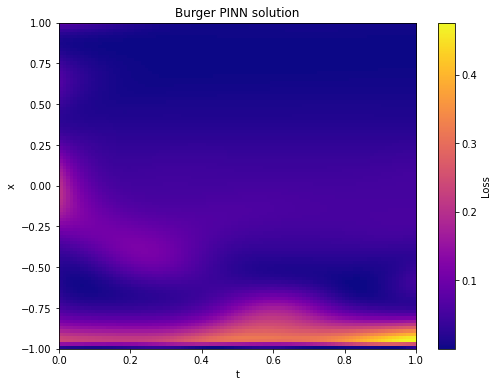

In [11]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Assuming x_grid and t_grid are the grid points for x and t
x_grid = jnp.linspace(0, 1, N)
t_grid = jnp.linspace(0, 1, N)

# Create meshgrid for x and t
x_mesh, t_mesh = jnp.meshgrid(x_grid, t_grid, indexing="ij")
x_flat = x_mesh.flatten()
t_flat = t_mesh.flatten()

# Calculate loss over the flattened (x, t) meshgrid points
loss_values_flat = jax.vmap(loss_fn, (None, 0, 0))(state.params, x_flat, t_flat)

# Reshape loss values back to a 2D grid for heatmap plotting
loss_values = loss_values_flat.reshape((len(x_grid), len(t_grid)))

print(loss_values.mean(), loss_values.max())
# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(loss_values, extent=(0, T_MAX, X_MIN, X_MAX), origin="lower", aspect="auto", cmap="plasma")
plt.colorbar(label="Loss")
plt.xlabel("t")
plt.ylabel("x")
plt.title("Burger PINN solution")
plt.show()

In [12]:
"""
@jax.jit
def loss_fn(params, x, t):
    bc_1 = bc_loss(params, state, -1., t, 0.)
    bc_2 = bc_loss(params, state, 1., t, 0.)
    
    ic = bc_loss(params, state, x, 0., -jnp.sin(jnp.pi*x))
    
    res = pinn_loss(params, state, x, t) 

    return res, bc_1, bc_2, ic

key, _ = random.split(key)
x = random.uniform(key, minval=X_MIN, maxval=X_MAX, shape=(BS,))
key, _ = random.split(key)
t = random.uniform(key, minval=0, maxval=T_MAX, shape=(BS,))
t = t.sort(axis=-1)

res, bc_1, bc_2, ic = jax.vmap(loss_fn, (None, 0, 0))(state.params, x, t)
"""

'\n@jax.jit\ndef loss_fn(params, x, t):\n    bc_1 = bc_loss(params, state, -1., t, 0.)\n    bc_2 = bc_loss(params, state, 1., t, 0.)\n    \n    ic = bc_loss(params, state, x, 0., -jnp.sin(jnp.pi*x))\n    \n    res = pinn_loss(params, state, x, t) \n\n    return res, bc_1, bc_2, ic\n\nkey, _ = random.split(key)\nx = random.uniform(key, minval=X_MIN, maxval=X_MAX, shape=(BS,))\nkey, _ = random.split(key)\nt = random.uniform(key, minval=0, maxval=T_MAX, shape=(BS,))\nt = t.sort(axis=-1)\n\nres, bc_1, bc_2, ic = jax.vmap(loss_fn, (None, 0, 0))(state.params, x, t)\n'

In [13]:
import jax
import jax.numpy as jnp

def compute_grad_norm(params, loss_fn, *args):
    # Compute gradients of the loss w.r.t. each parameter    
    grads = jax.grad(loss_fn)(params, *args)
    
    # Flatten all gradients into a single vector
    flat_grads = jax.flatten_util.ravel_pytree(grads)[0]
    
    # Compute the L2 norm of the gradient vector
    grad_norm = jnp.linalg.norm(flat_grads)
    return grad_norm

@jax.jit
def batched_compute_lambdas(params, state, x, t):
    g_bc_1 = jax.vmap(compute_grad_norm, (None, None, None, None, 0, None))(params, bc_loss, state, -1., t, 0.)
    g_bc_2 = jax.vmap(compute_grad_norm, (None, None, None, None, 0, None))(params, bc_loss, state, 1., t, 0.)
    g_ic = jax.vmap(compute_grad_norm, (None, None, None, 0, None, 0))(params, bc_loss, state, x, 0., -jnp.sin(jnp.pi*x))
    g_res = jax.vmap(compute_grad_norm, (None, None, None, 0, 0))(params, pinn_loss, state, x, t)

    grad_norms = [g_bc_1, g_bc_2, g_ic, g_res]
    grad_norms = [jnp.sum(i) for i in grad_norms]
    total = sum(grad_norms)

    lambdas = [total/i for i in grad_norms]
    return jnp.array(lambdas)

"""
key, _ = random.split(key)
x = random.uniform(key, minval=X_MIN, maxval=X_MAX, shape=(BS,))
key, _ = random.split(key)
t = random.uniform(key, minval=0, maxval=T_MAX, shape=(BS,))
t = t.sort(axis=-1)

batched_compute_lambdas(params, state, x, t)
"""

'\nkey, _ = random.split(key)\nx = random.uniform(key, minval=X_MIN, maxval=X_MAX, shape=(BS,))\nkey, _ = random.split(key)\nt = random.uniform(key, minval=0, maxval=T_MAX, shape=(BS,))\nt = t.sort(axis=-1)\n\nbatched_compute_lambdas(params, state, x, t)\n'

In [14]:
key = random.PRNGKey(0)
model = MLP(num_hidden=64, num_output=1)
input_shape = (2,)

# Create the exponential decay schedule
lr = optax.exponential_decay(
    init_value=config.learning_rate,
    transition_steps=config.decay_steps,
    decay_rate=config.decay_rate,
    staircase=config.staircase,
)

state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=model.init(key, jnp.ones(input_shape)),
    tx=optax.adam(learning_rate=lr)        
)

  0%|          | 0/100 [00:00<?, ?it/s]

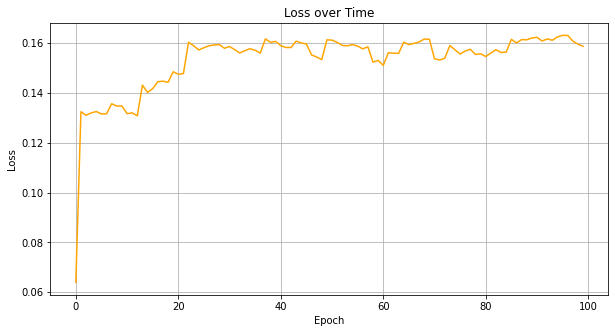

In [19]:
from jax.lax import stop_gradient

@jax.jit
def batch_train_step(state, x, t, lambdas):
    def loss_fn(params, x, t):
        bc_1 = bc_loss(params, state, -1., t, 0.)*lambdas[0]
        bc_2 = bc_loss(params, state, 1., t, 0.)*lambdas[1]
        ic = bc_loss(params, state, x, 0., -jnp.sin(jnp.pi*x))*lambdas[2]
        res = pinn_loss(params, state, x, t)*lambdas[3]

        return res + bc_1 + bc_2 + ic
    
    def batched_loss(params, x, t):
        losses = jax.vmap(loss_fn, (None, 0, 0))(params, x, t)

        cum_loss = jnp.cumsum(stop_gradient(losses))
        weights = jnp.exp(-cum_loss / jnp.max(cum_loss))
        loss = jnp.mean(weights * losses)

        return loss

    grad_fn = jax.value_and_grad(batched_loss)
    loss, grads = grad_fn(state.params, x, t)

    state = state.apply_gradients(grads=grads)

    return state, loss


T_MAX = 1
X_MIN = -1
X_MAX = 1
N_EPOCHS = 25
STEPS = 1000
BS = 128

lambdas = jnp.ones(4)

losses = []
for epoch in (pbar := tqdm(range(N_EPOCHS))):
    mean_loss = 0
    for i in range(STEPS):
        key, _ = random.split(key)
        x = random.uniform(key, minval=X_MIN, maxval=X_MAX, shape=(BS,))
        key, _ = random.split(key)
        t = random.uniform(key, minval=0, maxval=T_MAX, shape=(BS,))
        t = t.sort(axis=-1)
            
        state, loss = batch_train_step(state, x, t, lambdas)
    
        mean_loss += loss   # Accumulate mean loss over STEPS
        
    if epoch % 3 == 0: # loss balancing
        lambdas = batched_compute_lambdas(state.params, state, x, t)
        
    mean_loss = mean_loss / STEPS
    losses.append(mean_loss)
        
    # Update tqdm bar with mean loss
    pbar.set_description(f"Loss {mean_loss: .4f}")
    
plot_loss_over_time(losses)

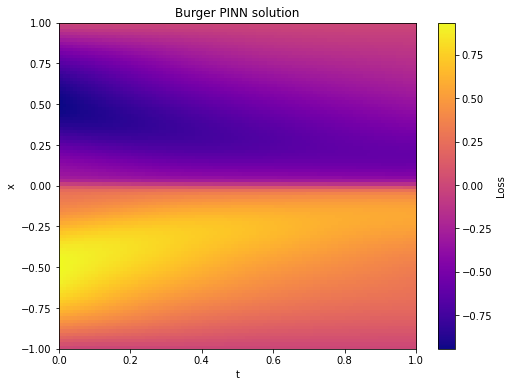

In [20]:
N = 100
x_grid = jnp.linspace(X_MIN, X_MAX, N)
t_grid = jnp.linspace(0, T_MAX, N)

# jax.vmap(fwd, (None, None, 0, 0))(state.params, state, x_grid, t_grid)
# Create a meshgrid of x and t values
x_mesh, t_mesh = jnp.meshgrid(x_grid, t_grid, indexing="ij")
x_flat = x_mesh.flatten()
t_flat = t_mesh.flatten()

# Use vmap over the flattened array
results_flat = jax.vmap(fwd, (None, None, 0, 0))(state.params, state, x_flat, t_flat)

# Reshape the result back into a (50, 50, ...) grid
results = results_flat.reshape((N, N, -1))  # Adjust shape based on fwd's output
results.shape

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(results, extent=(0, T_MAX, X_MIN, X_MAX), origin="lower", aspect="auto", cmap="plasma")
plt.colorbar(label="Loss")
plt.xlabel("t")
plt.ylabel("x")
plt.title("Burger PINN solution")
plt.show()

0.17928329 1.5916591


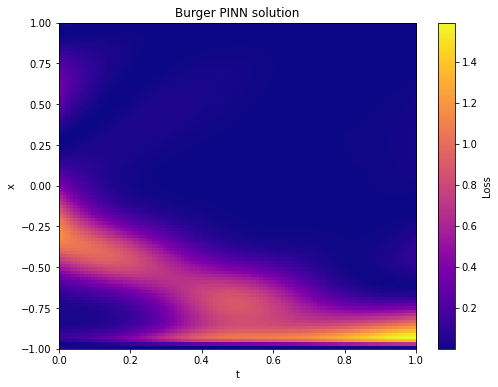

In [21]:
@jax.jit
def loss_fn(params, x, t):
    bc_1 = bc_loss(params, state, -1., t, 0.)
    bc_2 = bc_loss(params, state, 1., t, 0.)
    
    ic = bc_loss(params, state, x, 0., -jnp.sin(jnp.pi*x))
    
    res = pinn_loss(params, state, x, t) 

    return res + bc_1 + bc_2 + ic

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Assuming x_grid and t_grid are the grid points for x and t
x_grid = jnp.linspace(0, 1, N)
t_grid = jnp.linspace(0, 1, N)

# Create meshgrid for x and t
x_mesh, t_mesh = jnp.meshgrid(x_grid, t_grid, indexing="ij")
x_flat = x_mesh.flatten()
t_flat = t_mesh.flatten()

# Calculate loss over the flattened (x, t) meshgrid points
loss_values_flat = jax.vmap(loss_fn, (None, 0, 0))(state.params, x_flat, t_flat)

# Reshape loss values back to a 2D grid for heatmap plotting
loss_values = loss_values_flat.reshape((len(x_grid), len(t_grid)))
print(loss_values.mean(), loss_values.max())
# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(loss_values, extent=(0, T_MAX, X_MIN, X_MAX), origin="lower", aspect="auto", cmap="plasma")
plt.colorbar(label="Loss")
plt.xlabel("t")
plt.ylabel("x")
plt.title("Burger PINN solution")
plt.show()

In [66]:
glorot = glorot_normal()
class MLP_fourier(nn.Module):
    kernel_init: Callable
    num_input: int
    num_hidden: int
    num_output: int
    B: jnp.array
    
    @nn.compact
    def __call__(self, x):
        # fourier feature embeddings
        x = jnp.matmul(self.B, x)
        x = jnp.concatenate([jnp.cos(x), jnp.sin(x)])
        
        x = nn.Dense(self.num_hidden, kernel_init=self.kernel_init)(x)
        x = nn.tanh(x)
        x = nn.Dense(self.num_hidden, kernel_init=self.kernel_init)(x)
        x = nn.tanh(x)
        x = nn.Dense(self.num_output, kernel_init=self.kernel_init)(x)
        return x
    
std = 5
B = jax.random.normal(key, (64//2,2)) * std

key = random.PRNGKey(0)
model = MLP_fourier(glorot, 2, 64, 1, B)
input_shape = (2,)

# Create the exponential decay schedule
lr = optax.exponential_decay(
    init_value=config.learning_rate,
    transition_steps=config.decay_steps,
    decay_rate=config.decay_rate,
    staircase=config.staircase,
)

state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=model.init(key, jnp.ones(input_shape)),
    tx=optax.adam(learning_rate=lr)        
)

state.apply_fn(state.params, jnp.array([0., 0.]))

Array([-0.25639313], dtype=float32)

  0%|          | 0/25 [00:00<?, ?it/s]

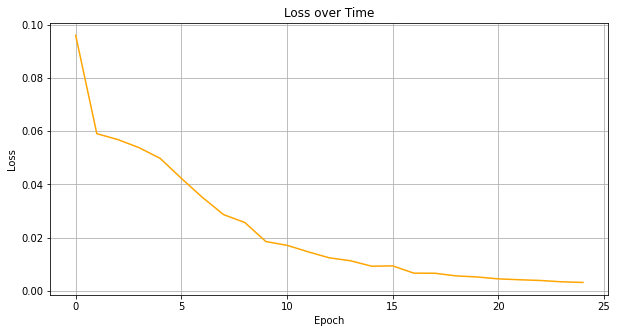

In [67]:
@jax.jit
def batch_train_step(state, x, t):
    def loss_fn(params, x, t):
        bc_1 = bc_loss(params, state, -1., t, 0.)
        bc_2 = bc_loss(params, state, 1., t, 0.)

        ic = bc_loss(params, state, x, 0., -jnp.sin(jnp.pi*x))

        res = pinn_loss(params, state, x, t) 

        return res + bc_1 + bc_2 + ic
    
    def batched_loss(params, x, t):
        losses = jax.vmap(loss_fn, (None, 0, 0))(params, x, t)

        cum_loss = jnp.cumsum(stop_gradient(losses))
        weights = jnp.exp(-cum_loss / jnp.max(cum_loss))
        loss = jnp.mean(weights * losses)

        return loss

    grad_fn = jax.value_and_grad(batched_loss)
    loss, grads = grad_fn(state.params, x, t)

    state = state.apply_gradients(grads=grads)

    return state, loss


T_MAX = 1
X_MIN = -1
X_MAX = 1
N_EPOCHS = 25
STEPS = 1000
BS = 128

losses = []
for epoch in (pbar := tqdm(range(N_EPOCHS))):
    mean_loss = 0
    for i in range(STEPS):
        key, _ = random.split(key)
        x = random.uniform(key, minval=X_MIN, maxval=X_MAX, shape=(BS,))
        key, _ = random.split(key)
        t = random.uniform(key, minval=0, maxval=T_MAX, shape=(BS,))
        t = t.sort(axis=-1)
            
        state, loss = batch_train_step(state, x, t)
    
        mean_loss += loss   # Accumulate mean loss over STEPS
    mean_loss = mean_loss / STEPS
    losses.append(mean_loss)
        
    # Update tqdm bar with mean loss
    pbar.set_description(f"Loss {mean_loss: .4f}")
    
plot_loss_over_time(losses)

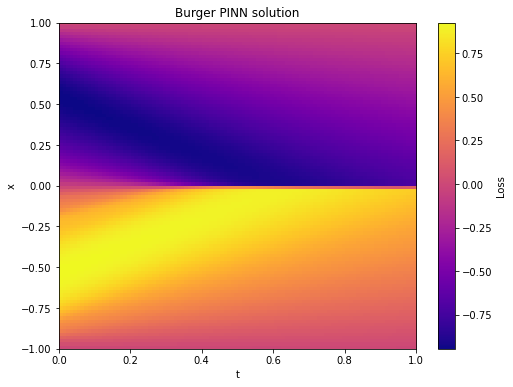

In [68]:
def plot_heatmap(arr, title):
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(arr, extent=(0, T_MAX, X_MIN, X_MAX), origin="lower", aspect="auto", cmap="plasma")
    plt.colorbar(label="Loss")
    plt.xlabel("t")
    plt.ylabel("x")
    plt.title(title)
    plt.show()
    
N = 100
x_grid = jnp.linspace(X_MIN, X_MAX, N)
t_grid = jnp.linspace(0, T_MAX, N)

x_mesh, t_mesh = jnp.meshgrid(x_grid, t_grid, indexing="ij")
x_flat = x_mesh.flatten()
t_flat = t_mesh.flatten()

results = results_flat.reshape((N, N, -1))

plot_heatmap(results, title="Burger PINN solution")

0.0035354763 0.18647818


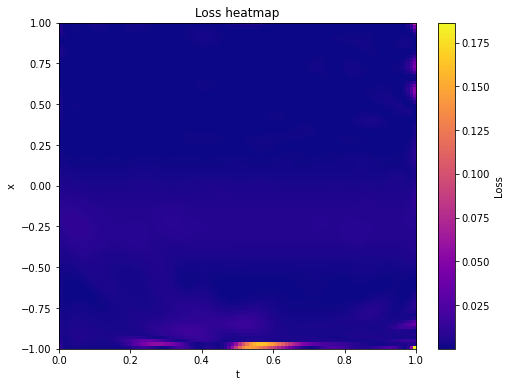

In [70]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Assuming x_grid and t_grid are the grid points for x and t
x_grid = jnp.linspace(0, 1, N)
t_grid = jnp.linspace(0, 1, N)

# Create meshgrid for x and t
x_mesh, t_mesh = jnp.meshgrid(x_grid, t_grid, indexing="ij")
x_flat = x_mesh.flatten()
t_flat = t_mesh.flatten()

# Calculate loss over the flattened (x, t) meshgrid points
loss_values_flat = jax.vmap(loss_fn, (None, 0, 0))(state.params, x_flat, t_flat)

# Reshape loss values back to a 2D grid for heatmap plotting
loss_values = loss_values_flat.reshape((len(x_grid), len(t_grid)))

print(loss_values.mean(), loss_values.max())
plot_heatmap(loss_values, title="Loss heatmap")

In [86]:
# random weight factorization
# get, g, v parameters, named kernel
# g, v = self.param("kernel", init_fn, )
# kernel = g * v
# bias = self.param
# y = jnp.dot(x, kernel) + bias

g = jnp.ones((3, 1))
v = jnp.ones((1, 3))
g * v

Array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float32)